In [47]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
import seaborn as sns
import skfuzzy as fuzz
from sklearn.decomposition import PCA

data = pd.read_csv('Hasil_Gabungan.csv')
data.head()

,Province,Residential_2021,Industrial_2021,Business_2021,Social_2021,Gov_Office_2021,Pub_Street_2021,Total_2021,Residential_2022,Industrial_2022,...,Social,Gov_Office,Pub_Street,Total,JP_2021,JP_2022,JP_2023,KP_2021,KP_2022,KP_2023
0,Aceh,1929.59,190.56,515.04,208.23,107.18,123.87,3074.47,1895.07,228.77,...,251.10,115.55,133.98,3458.30,5274.9,5334.9,5409.2,904.88,894.55,1110.82
1,Sumatera Utara,5998.75,3082.97,1672.31,432.68,146.38,415.31,11748.40,6025.69,3152.63,...,576.89,158.68,420.80,12472.84,14799.4,14970.5,15180.5,4603.58,4612.67,4066.51
2,Sumatera Barat,1781.19,945.24,573.70,169.92,80.45,95.70,3646.20,1791.64,827.73,...,217.24,86.04,100.31,3810.84,5534.5,5597.3,5677.6,1031.49,1012.23,1026.11
3,Riau,2935.09,1593.61,1130.68,222.55,112.15,114.24,6108.32,3007.32,2960.77,...,296.71,119.24,114.71,8212.56,6394.1,6466.8,6555.8,1429.86,1492.82,1509.77
4,Kep. Riau,496.87,39.99,277.41,36.63,39.17,22.77,912.84,499.83,39.76,...,45.74,43.43,23.45,999.60,2064.6,2089.9,2121.5,757.43,956.84,1053.13


In [48]:
features1 = ['Residential_2021', 'Business_2021', 'Industrial_2021', 'Social_2021', 'Gov_Office_2021', 'Pub_Street_2021', 'Total_2021', 'JP_2021', 'KP_2021']

data_2021 = data[features1]

scaler = RobustScaler()
scaled_features = scaler.fit_transform(data_2021)
np.random.seed(42)

In [49]:
k = 2
cntr, u, _, _, _, _, _ = fuzz.cmeans(scaled_features.T, c=k, m=2, error=0.005, maxiter=1000)

cluster_labels = np.argmax(u, axis=0)

data['Cluster'] = cluster_labels

for cluster_num in range(k):
    print(f"\nProvinsi dalam Cluster {cluster_num}:")
    provinces_in_cluster = data[data['Cluster'] == cluster_num]['Province'].tolist()
    print(provinces_in_cluster)

    print(f"Nilai data point untuk Cluster {cluster_num}:")
    print(cntr[cluster_num])



Provinsi dalam Cluster 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Kep. Riau', 'Sumatera Selatan', 'Jambi', 'Bengkulu', 'Kep. Bangka Belitung', 'Lampung', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Sulawesi Utara', 'Gorontalo', 'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Papua Barat', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'DI Yogyakarta', 'Kalimantan Timur', 'Kalimantan Utara']
Nilai data point untuk Cluster 0:
[ 0.05231218  0.05264173  0.24306116  0.16333118 -0.01233663  0.07892532
  0.14479224  0.00164233  0.15686107]

Provinsi dalam Cluster 1:
['Jawa Timur', 'Jawa Tengah', 'Jawa Barat', 'Banten', 'DKI Jakarta']
Nilai data point untuk Cluster 1:
[ 5.82344624  5.67722934 14.16823572  5.93214263  6.0885765   3.31726824
  7.96468842  5.01043846  7.37135861]


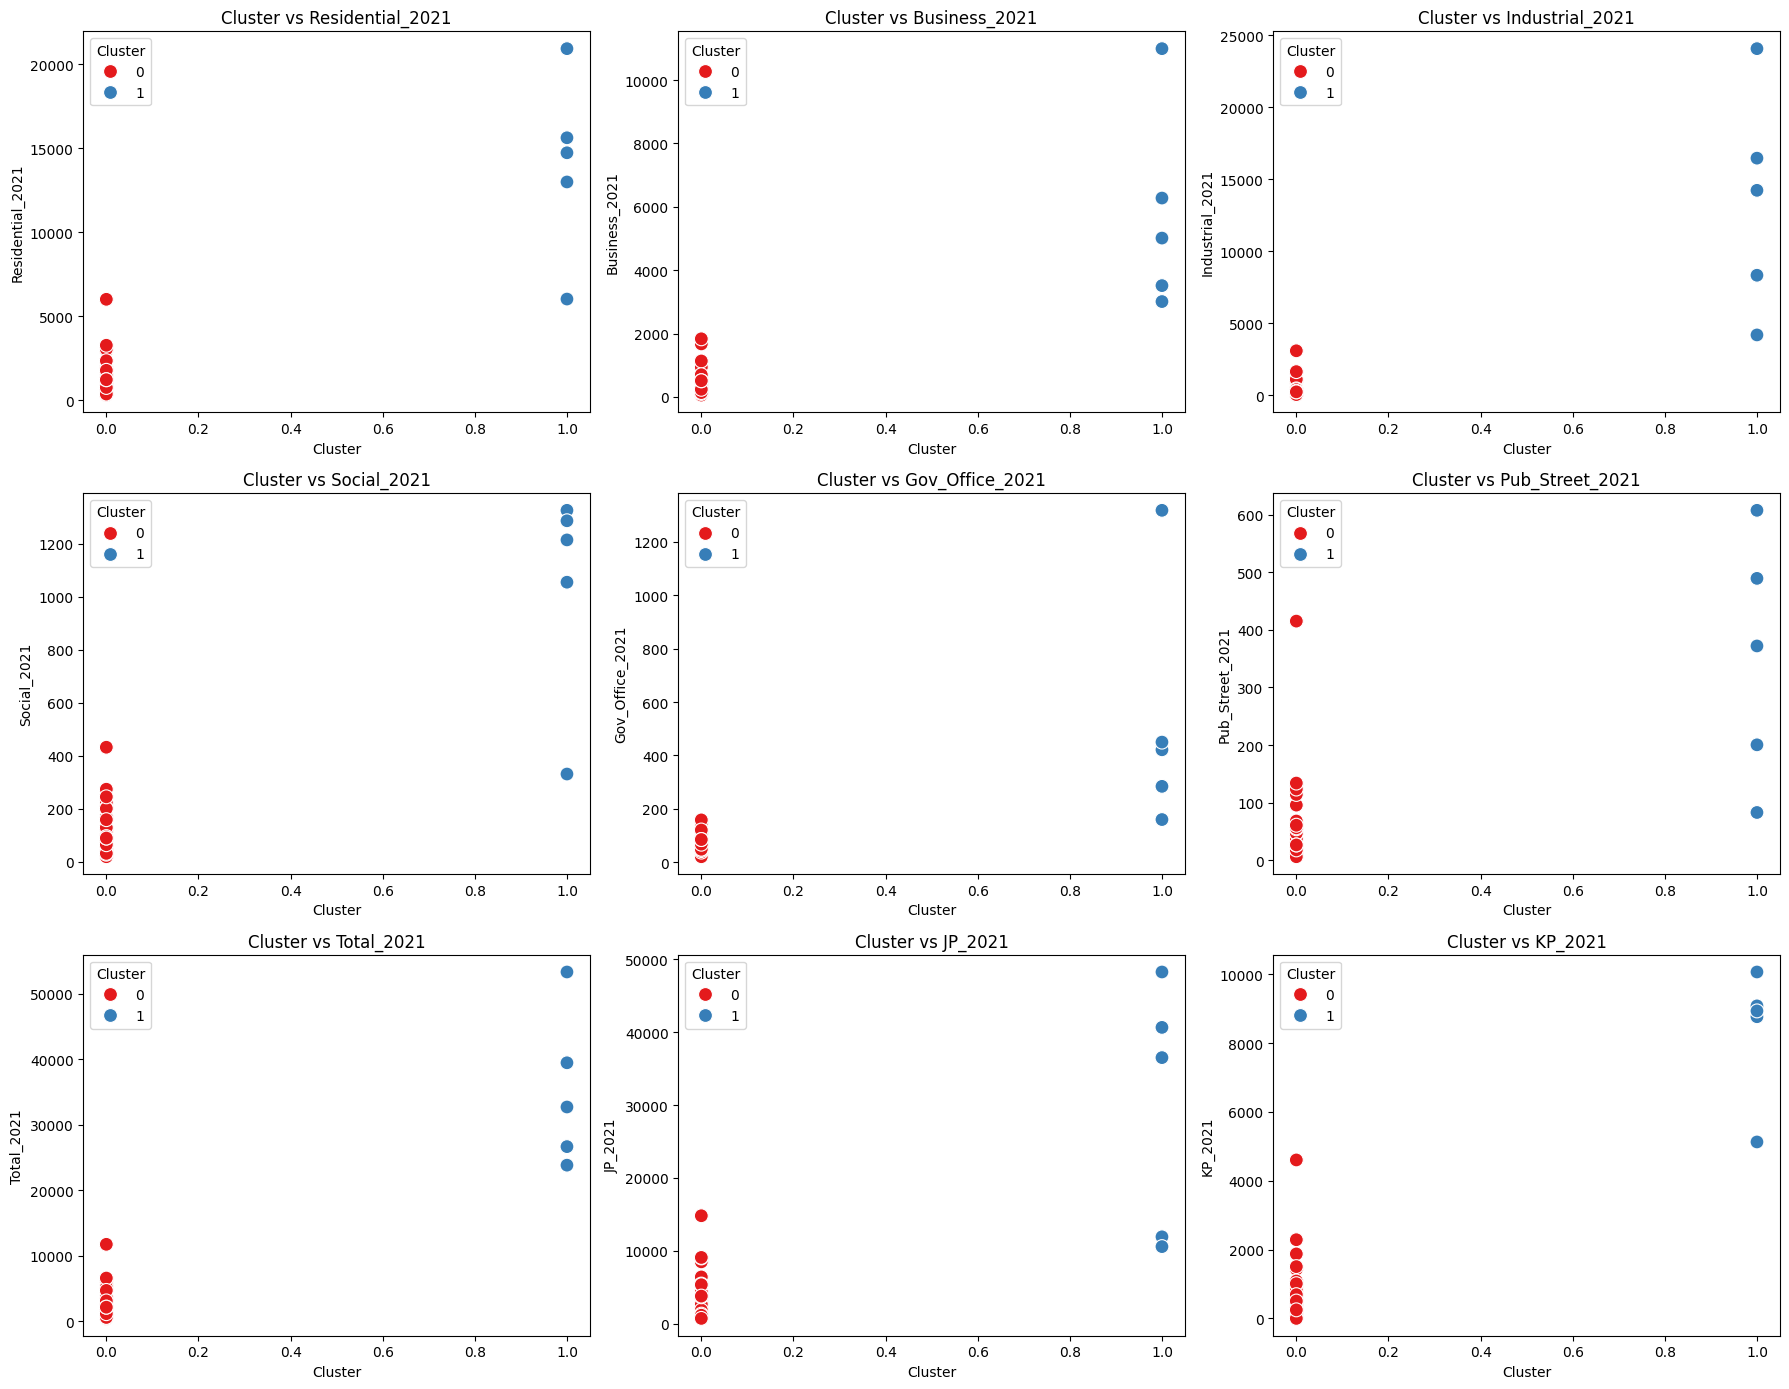

In [63]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features1, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster', y=feature, data=data, hue='Cluster', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [51]:
features2 = ['Residential_2022', 'Business_2022', 'Industrial_2022', 'Social_2022', 'Gov_Office_2022', 'Pub_Street_2022', 'Total_2022', 'JP_2022', 'KP_2022']

data_2022 = data[features2]

scaler2 = RobustScaler()
scaled_features2 = scaler2.fit_transform(data_2022)
np.random.seed(42)

In [52]:
k = 2
cntr2, u2, _, _, _, _, _ = fuzz.cmeans(scaled_features2.T, c=k, m=2, error=0.005, maxiter=1000)

cluster_labels2 = np.argmax(u2, axis=0)

data['Cluster2'] = cluster_labels2

for cluster_num2 in range(k):
    print(f"\nProvinsi dalam Cluster2 {cluster_num2}:")
    provinces_in_cluster2 = data[data['Cluster2'] == cluster_num2]['Province'].tolist()
    print(provinces_in_cluster2)

    print(f"Nilai data point untuk Cluster2 {cluster_num2}:")
    print(cntr2[cluster_num2])



Provinsi dalam Cluster2 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Kep. Riau', 'Sumatera Selatan', 'Jambi', 'Bengkulu', 'Kep. Bangka Belitung', 'Lampung', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Sulawesi Utara', 'Gorontalo', 'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Papua Barat', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'DI Yogyakarta', 'Kalimantan Timur', 'Kalimantan Utara']
Nilai data point untuk Cluster2 0:
[ 0.05831709  0.08825115  0.3256108   0.15821053 -0.00117195  0.13479958
  0.17061994 -0.03767697  0.05546085]

Provinsi dalam Cluster2 1:
['Jawa Timur', 'Jawa Tengah', 'Jawa Barat', 'Banten', 'DKI Jakarta']
Nilai data point untuk Cluster2 1:
[ 5.76984298  5.97287214 14.30616903  5.87621338  6.37898727  3.38953061
  7.94767711  7.28816141  8.70409881]


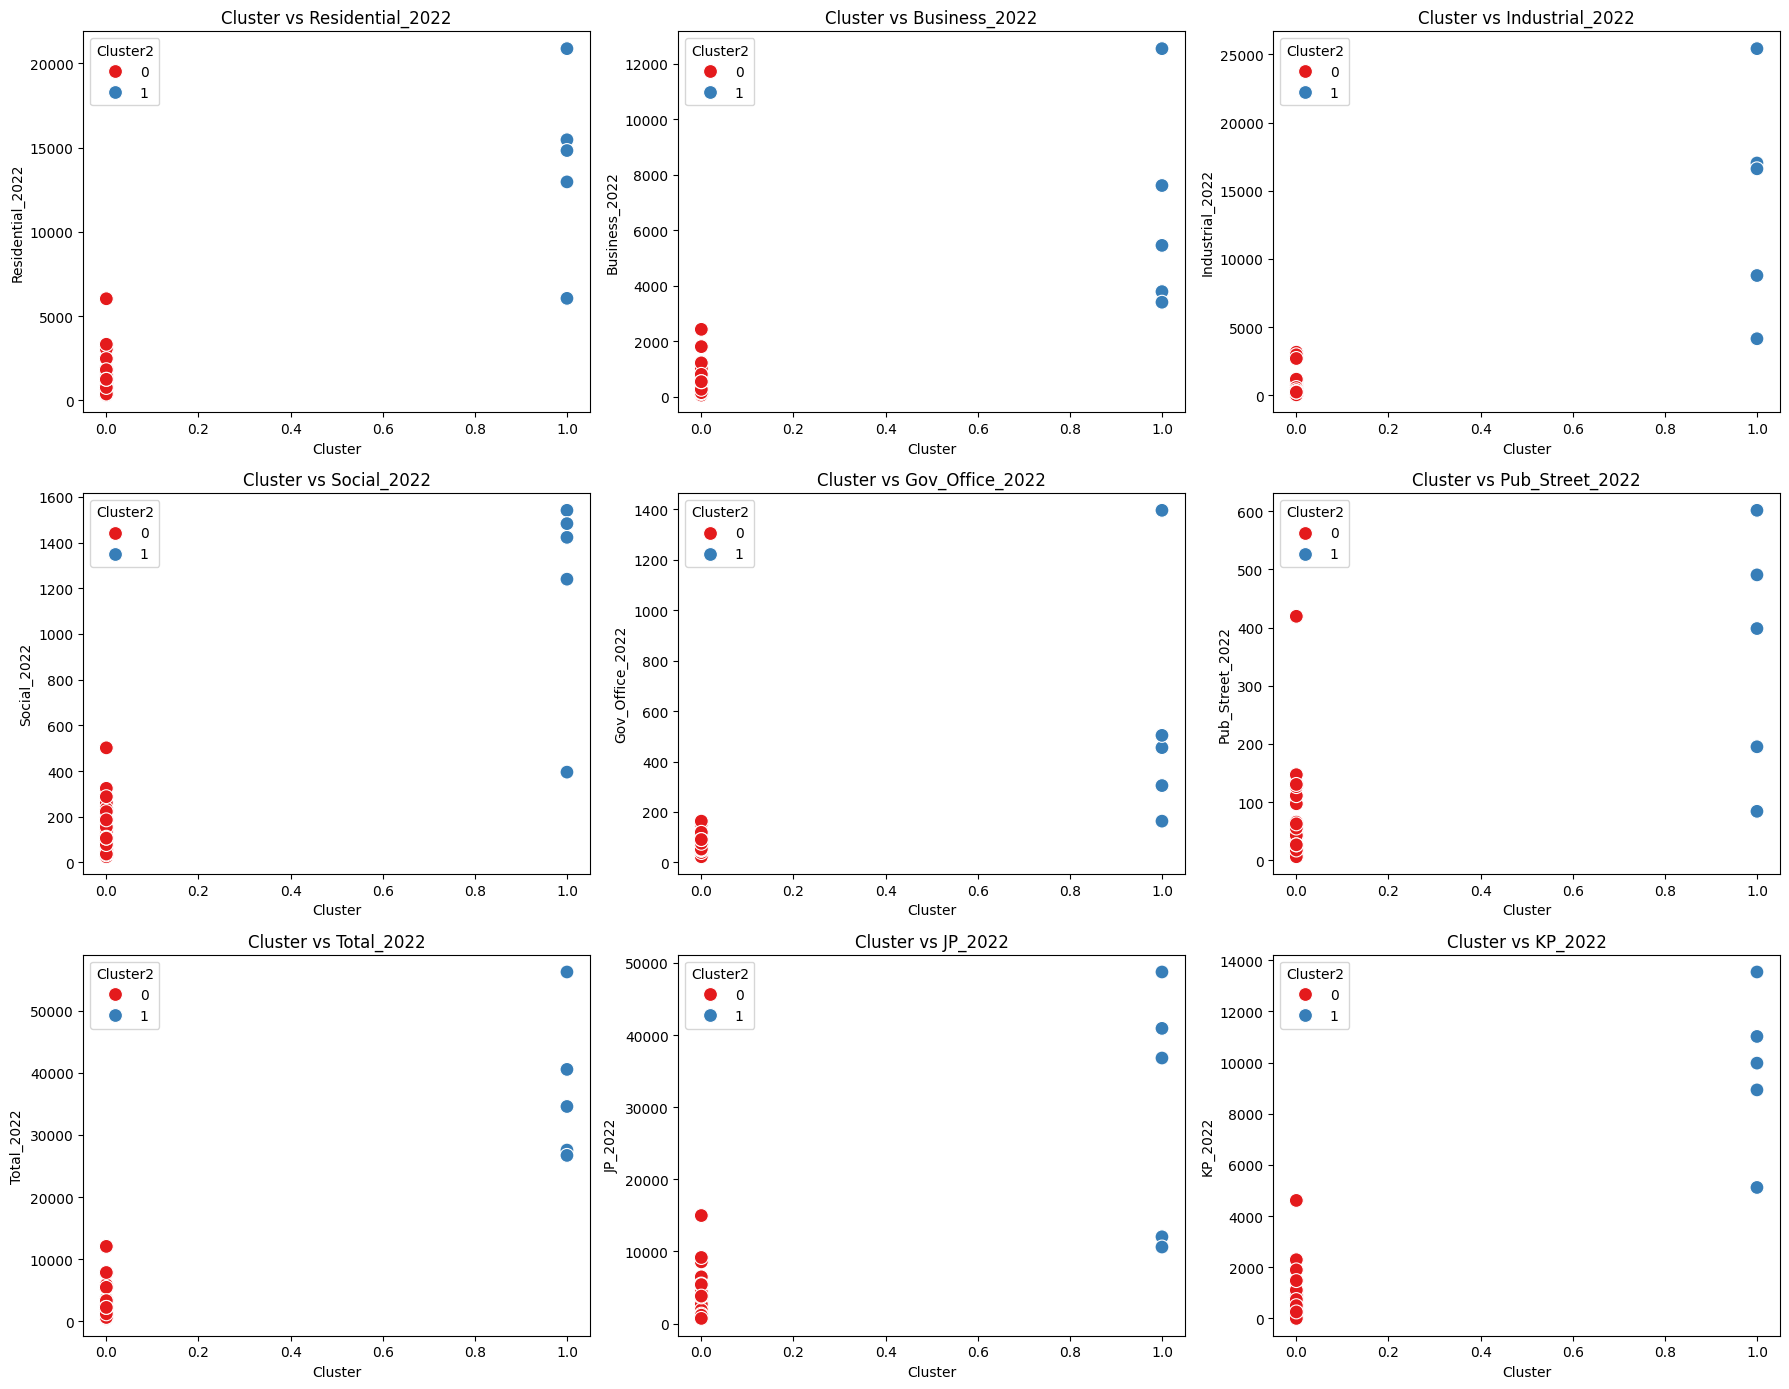

In [61]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features2, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster2', y=feature, data=data, hue='Cluster2', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [54]:
features3 = ['Residential', 'Business', 'Industrial', 'Social', 'Gov_Office', 'Pub_Street', 'Total', 'JP_2023', 'KP_2023']

data_2023 = data[features3]

scaler3 = RobustScaler()
scaled_features3 = scaler3.fit_transform(data_2023)
np.random.seed(42)

In [55]:
k = 2
cntr3, u3, _, _, _, _, _ = fuzz.cmeans(scaled_features3.T, c=k, m=2, error=0.005, maxiter=1000)

cluster_labels3 = np.argmax(u3, axis=0)

data['Cluster3'] = cluster_labels3

for cluster_num3 in range(k):
    print(f"\nProvinsi dalam Cluster3 {cluster_num3}:")
    provinces_in_cluster3 = data[data['Cluster3'] == cluster_num3]['Province'].tolist()
    print(provinces_in_cluster3)

    print(f"Nilai data point untuk Cluster3 {cluster_num3}:")
    print(cntr[cluster_num3])



Provinsi dalam Cluster3 0:
['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Kep. Riau', 'Sumatera Selatan', 'Jambi', 'Bengkulu', 'Kep. Bangka Belitung', 'Lampung', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Sulawesi Utara', 'Gorontalo', 'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara', 'Sulawesi Barat', 'Maluku', 'Maluku Utara', 'Papua', 'Papua Barat', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'DI Yogyakarta', 'Kalimantan Timur', 'Kalimantan Utara']
Nilai data point untuk Cluster3 0:
[ 0.05231218  0.05264173  0.24306116  0.16333118 -0.01233663  0.07892532
  0.14479224  0.00164233  0.15686107]

Provinsi dalam Cluster3 1:
['Jawa Timur', 'Jawa Tengah', 'Jawa Barat', 'Banten', 'DKI Jakarta']
Nilai data point untuk Cluster3 1:
[ 5.82344624  5.67722934 14.16823572  5.93214263  6.0885765   3.31726824
  7.96468842  5.01043846  7.37135861]


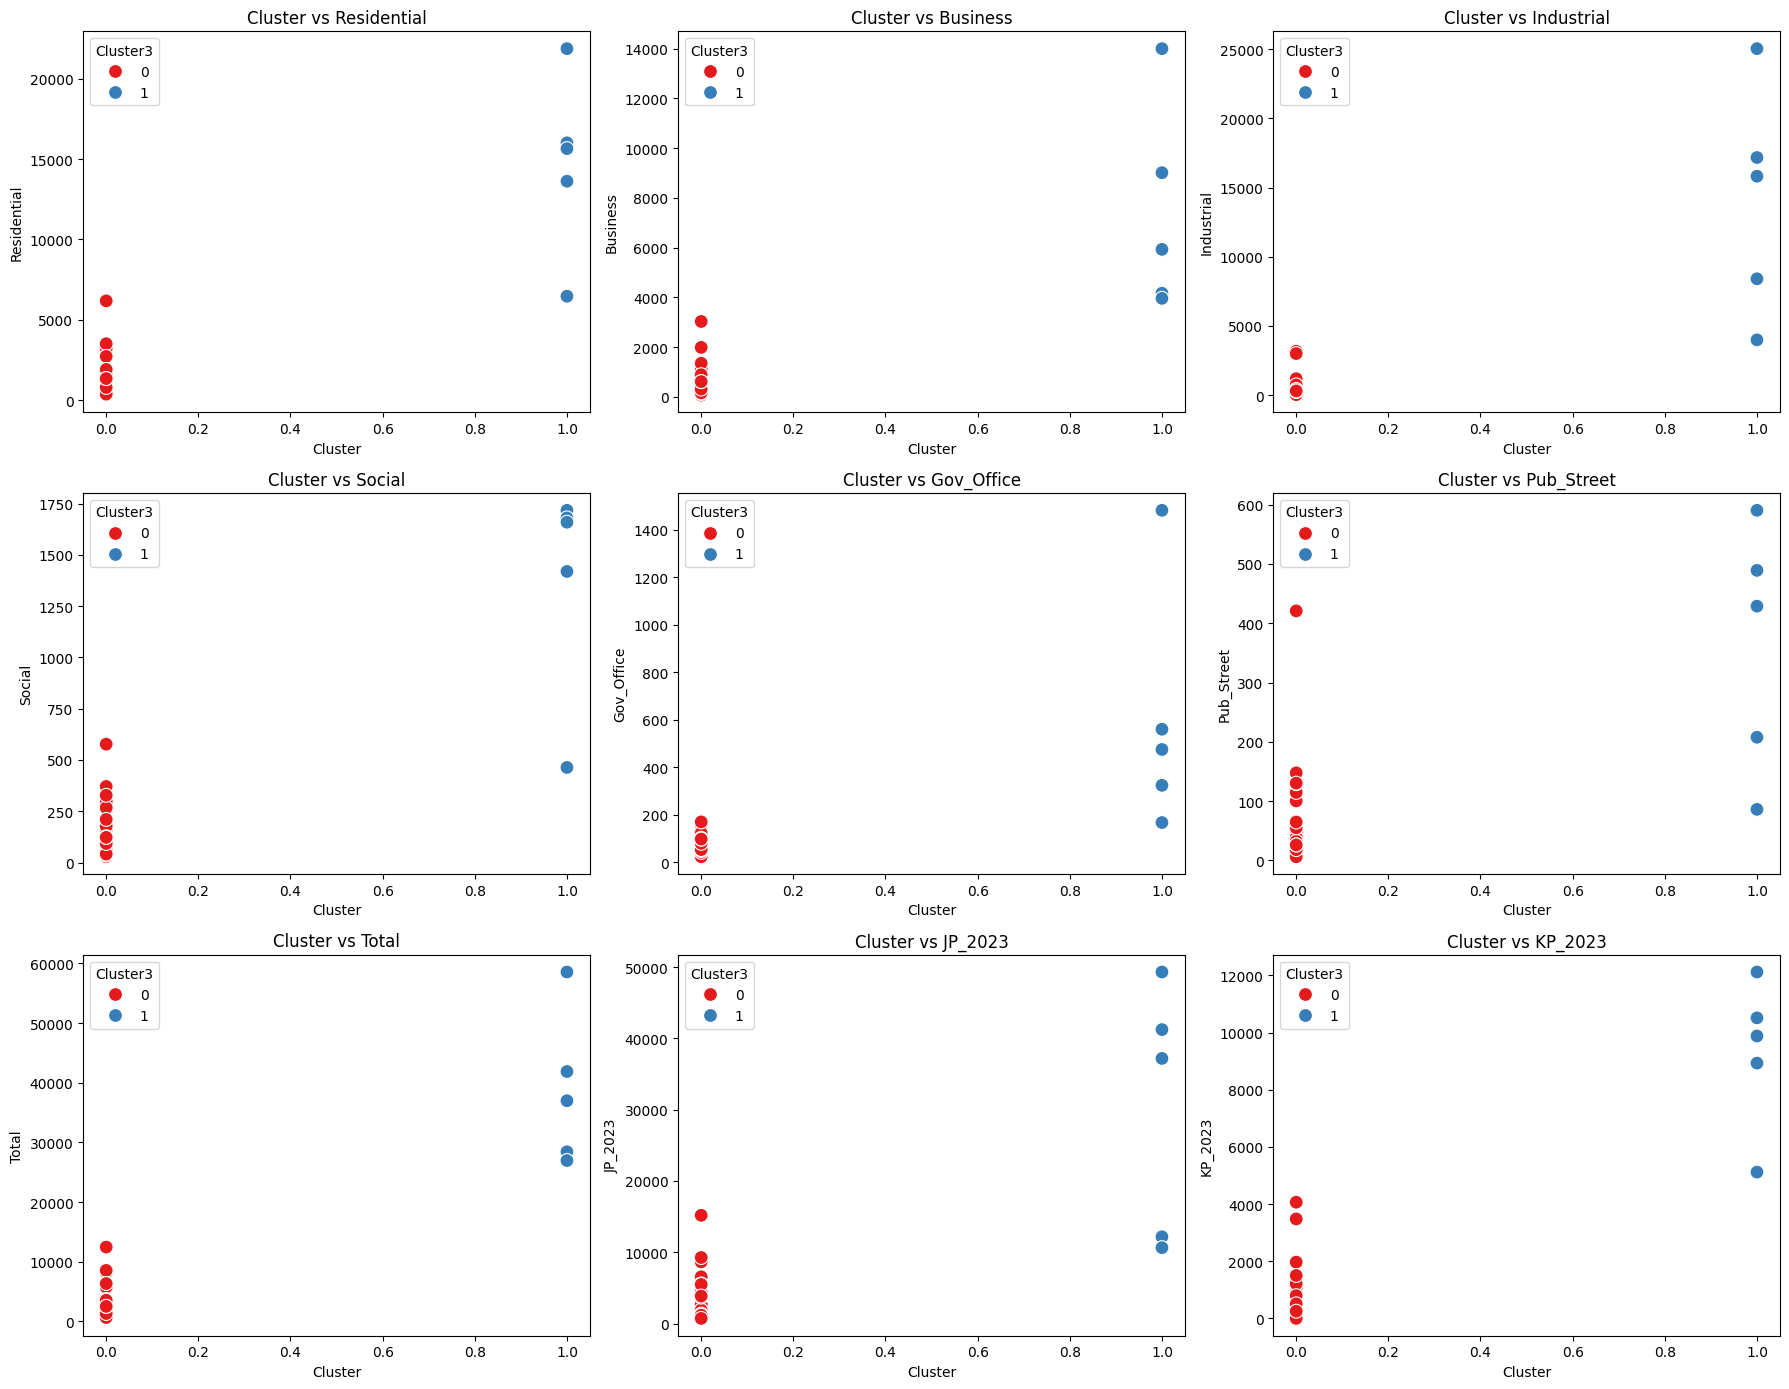

In [59]:
plt.figure(figsize=(18, 14))  

for i, feature in enumerate(features3, 1):
    plt.subplot(3, 3, i)  
    sns.scatterplot(x='Cluster3', y=feature, data=data, hue='Cluster3', palette='Set1', s=100)
    plt.title(f'Cluster vs {feature}')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature}')

plt.tight_layout()
plt.show()

In [57]:
from sklearn.metrics import silhouette_score

sil_score_2021 = silhouette_score(scaled_features, data['Cluster'])
print(f"Silhouette Score untuk 2021: {sil_score_2021}")


sil_score_2022 = silhouette_score(scaled_features2, data['Cluster2'])
print(f"Silhouette Score untuk 2022: {sil_score_2022}")

sil_score_2023 = silhouette_score(scaled_features3, data['Cluster3'])
print(f"Silhouette Score untuk 2023: {sil_score_2023}")


Silhouette Score untuk 2021: 0.8133220488555215
Silhouette Score untuk 2022: 0.8116370248906389
Silhouette Score untuk 2023: 0.8052039869077368
